# IIA 2024 - Aprendizaje Automatizado

## Introducción a Redes Neuronales

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sklearn as skl
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier

import warnings
from sklearn.exceptions import ConvergenceWarning

from copy import deepcopy

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

def cargar_csv(path, xcols=2, dw=False):
    """
    Argumentos:
      path (str): ruta al archivo csv a cargar
      xcols (int): cantidad de columnas que representan las entradas,
        la columna restante representara la clase o dato de salida
    """
    df = pd.read_csv(path, header=None, delim_whitespace=dw)
    X = df.loc[:, 0:(xcols-1)]
    y = df.loc[:, xcols]
    return X,y

def cargar_csv2(path, dw=False):
    """
    Argumentos:
      path (str): ruta al archivo csv a cargar
      xcols (int): cantidad de columnas que representan las entradas,
        la columna restante representara la clase o dato de salida
    """
    df = pd.read_csv(path, header=None, delim_whitespace=dw)
    X = df.loc[:, :-1]
    y = df.loc[:, -1]
    return X,y

def entrenar_red(red, evaluaciones,
                 X_train, y_train,
                 X_val,   y_val,
                 X_test,  y_test):
    """
    Función que entrena una red ya definida previamente "evaluaciones" veces,
    cada vez entrenando un número de épocas elegido al crear la red y midiendo
    el error en train, validación y test al terminar ese paso de entrenamiento.
    Guarda y devuelve la red en el paso de evaluación que da el mínimo error de
    validación.

    Argumentos:
      red: red neuronal predefinida
      evaluaciones (int): las veces que evalua
      X_{}: los conjuntos de valores de entrada de train, validación y test
      y_{}: los conjuntos de valores de salida o clase

    Salidas:
      red: la red entrenada en el mínimo de validación
      error_{}: los errores de: train, validación y test medidos en cada
        evaluación
    """

    if type(red) == MLPClassifier:
      errorFunc = skl.metrics.zero_one_loss
    else:
      errorFunc = skl.metrics.mean_squared_error


    errorL_train = []
    errorL_val = []
    errorL_test = []
    best_err = 1.0
    best_red = red
    for epoch in range(evaluaciones):
      # red.partial_fit(X_train, y_train, classes=[0,1])
      ## Podríamos llamar partial_fit para realizar una sóla pasada a la vez,
      ## pero al ser muy costoso frenar y reanudar el entrenamiento realizamos
      ## varias épocas a la vez. Recordemos que la red fue definida con el
      ## parámetro 'sub-epocas', con lo cual cada llamado a 'fit' realiza esa
      ## cantidad de épocas
      red.fit(X_train, y_train)

      pred_train = red.predict(X_train)
      errorL_train.append(errorFunc(y_train, pred_train))

      pred_val = red.predict(X_val)
      error_val = errorFunc(y_val, pred_val)
      errorL_val.append(error_val)

      pred_test = red.predict(X_test)
      errorL_test.append(errorFunc(y_test, pred_test))

      if error_val < best_err:
        best_err = error_val
        best_red = deepcopy(red)

    return best_red, errorL_train, errorL_val, errorL_test

def entrenar_red_weight(red, evaluaciones,
                  X_train, y_train,
                  X_test,  y_test):

  if type(red) == MLPClassifier:
    errorFunc = skl.metrics.zero_one_loss
  else:
    errorFunc = skl.metrics.mean_squared_error

  errors_train, errors_test, pesos = [], [], []
  
  for n in range(evaluaciones):
    red.fit(X_train, y_train)
    
    pred_train = red.predict(X_train)
    errors_train.append(errorFunc(y_train, pred_train))

    pred_test = red.predict(X_test)
    errors_test.append(errorFunc(y_test, pred_test))

    layer_weights_sums = [np.sum(np.square(weights)) for weights in red.coefs_]
    total_weight_sum = np.sum(layer_weights_sums)
    pesos.append(total_weight_sum)

  return red, errors_train, errors_test, pesos

def rango_plot(super_epocas, sub_epocas):
    return np.array(range(super_epocas)) * sub_epocas

## Definimos nuestras redes

In [2]:
# Parámetros
"""
Comenzar y frenar el entrenamiento de una red es costoso, por lo que no
mediremos las métricas una vez por época, sino que haremos varias épocas a la
vez. Por ésto definimos sub-épocas, por ejemplo como 10, para realizar 10 épocas
a la vez y luego medir las métricas de error.
"""
sub_epocas=10   # numero de epocas que entrena cada vez
super_epocas=10 # numero de veces que realizaremos sub-epocas
# epocas = sub_epocas * super_epocas
eta=0.01        # learning rate
alfa=0.9        # momentum
N2=4            # neuronas en la capa oculta


# Defino MLP para regresión
def regresor():
    return MLPRegressor(
      hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=0.0,
      batch_size=1, learning_rate='constant', learning_rate_init=eta,
      momentum=alfa,nesterovs_momentum=False, tol=0.0, warm_start=True,
      max_iter=sub_epocas
    )


# Defino MLP para clasificación
def classifier():
    return MLPClassifier(
    hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=0.0,
    batch_size=1, learning_rate='constant', learning_rate_init=eta,
    momentum=alfa, nesterovs_momentum=False, tol=0.0, warm_start=True,
    max_iter=sub_epocas
    )


# Ejercicio 1: Capacidad de modelado
 Entrene redes neuronales para resolver el problema de clasificación de las espirales anidadas que creamos en el TP 0. Use un número creciente de neuronas en la capa intermedia: 2, 10, 20, 40. Valores posibles para los demás parámetros de entrenamiento: learning rate 0.1, momentum 0.9, 600 datos para ajustar los modelos (20% de ese conjunto separarlo al azar para conjunto de validación), 2000 para testear, 1000 evaluaciones del entrenamiento, cada una de 20 épocas. Para cada uno de los cuatro modelos obtenidos, graficar en el plano xy las clasificaciones sobre el conjunto de test. Comentar.

In [4]:
# Graficar resultados
def plot_results(df):

    xs0 = df[ df['Clase'] == 0 ].get('d1').to_numpy()
    ys0 = df[ df['Clase'] == 0 ].get('d2').to_numpy()
    xs1 = df[ df['Clase'] == 1 ].get('d1').to_numpy()
    ys1 = df[ df['Clase'] == 1 ].get('d2').to_numpy()

    plt.scatter(xs0, ys0, color='red', s=15)
    plt.scatter(xs1, ys1, color='blue', s=15)

    plt.show()


def espirales(n):

  # Generar puntos en coordenadas polares
  n_per_class = n // 2
  g1 = []
  g2 = []
  
  while (len(g1) < n_per_class or  len(g2) < n_per_class):

    # Generar punto aleatorio en un círculo de radio 1
    r = np.sqrt(np.random.uniform(0, 1))
    theta = np.random.uniform(-2 * np.pi, 5 * np.pi)

    # Convertir a coordenadas cartesianas
    x = r * np.cos(theta)
    y = r * np.sin(theta)

    # Determinar la clase del punto
    condition1 = (r >= theta / (4 * np.pi)) and (r <= (theta + np.pi) / (4 * np.pi))
    condition2 =  (r <= theta / (4 * np.pi)) and (r >= (theta - np.pi) / (4 * np.pi))

    if condition1 and len(g1) < n_per_class:
      g1.append((x, y))
    elif condition2 and len(g2) < n_per_class:
      g2.append((x, y))
        
  data1 = np.array(g1)
  data2 = np.array(g2)

  data = [[0, *x] for x in data1] + [[1, *x] for x in data2]
  df = pd.DataFrame(data, columns=(['Clase'] + ['d' + str(x + 1) for x in range(2)]))

  return df

In [ ]:
neurons = [2, 10, 20, 40]

def ej1(neurons):
  sub_epocas=20   # numero de epocas que entrena cada vez
  super_epocas=100 # numero de veces que realizaremos sub-epocas

  dfA = espirales(600)
  dfT = espirales(2000)

  X_test = dfT.drop('Clase', axis=1).to_numpy()
  y_test = dfT['Clase'].values

  X = dfA.drop('Clase', axis=1).to_numpy()
  y = dfA['Clase'].values


  # Spliteamos el training en training y validacion
  X_train, X_val, y_train, y_val = skl.model_selection.train_test_split(
    X, y, test_size=0.2) 
  
  net = MLPClassifier(
          hidden_layer_sizes=(neurons,), activation='logistic', solver='sgd', alpha=0.0,
          batch_size=1, learning_rate='constant', learning_rate_init=0.1,
          nesterovs_momentum=True, momentum=0.9, tol=0.0, warm_start=True,
          max_iter=sub_epocas
        )

  # Corremos el entrenamiento
  clasifRes, e_train, e_val, e_test = entrenar_red(
      net, super_epocas, X_train, y_train, X_val, y_val, X_test, y_test)

  y_out = clasifRes.predict(X_test)

  plt.scatter(X_test[:,0], X_test[:,1], c=y_out)
  plt.show()


c:\Users\bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


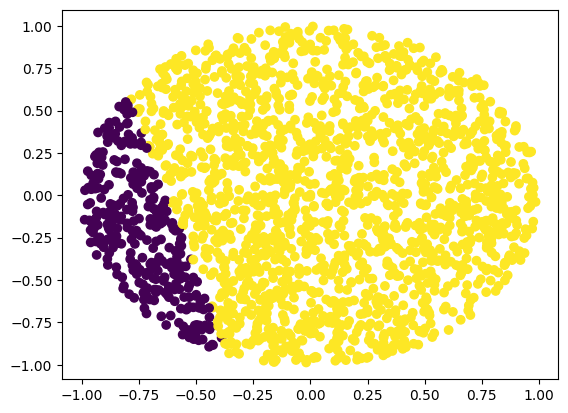

In [6]:
ej1(2)
# Clasificacion con 2 neuronas

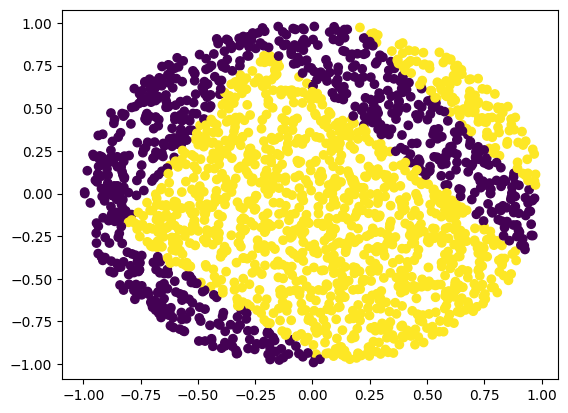

In [7]:
ej1(10)
# Clasificacion con 10 neuronas

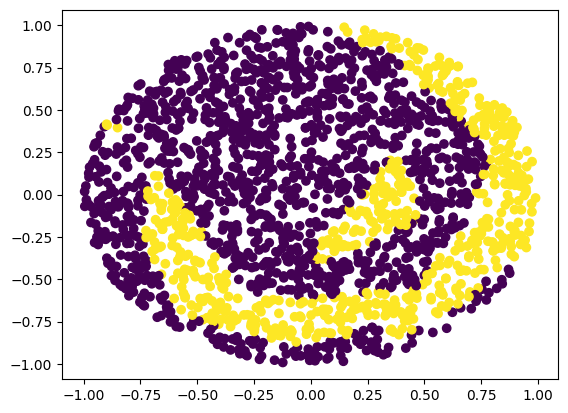

In [14]:
ej1(20)
# Clasificacion con 20 neuronas

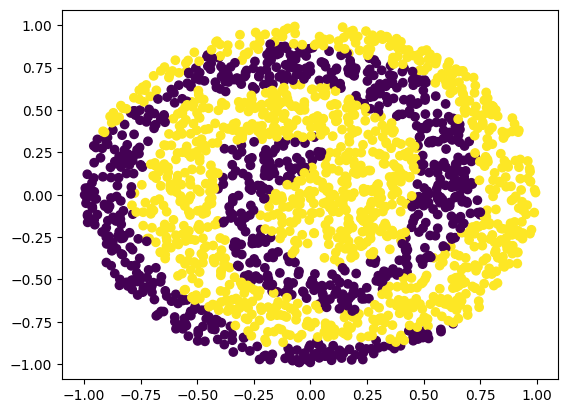

In [20]:
ej1(40)
# Clasificacion con 40 neuronas

## Comentarios
Puede verse que al aumentar la cantidad de neuronas, la capacidad de la red de inferir el comportamiento de la espiral aumenta.
En los casos con pocas neuronas, la red clasifica con un comportamiento muy basico, trazando lineas rectas. Mientras que en el caso con 40 neuronas,
 puede predecir un comportamiento mucho mas complejo.
Cabe destacar que en los casos con muchas neuronas, fue necesario entrenarla repetidas veces para lograr una red que clasifique de forma correcta. Muchas de las redes obtenidas
tuvieron un metodo de clasificacion complejo, pero con mucho error. Esto puede deberse a la cantidad de datos con los cuales se entreno la red.

# Ejercicio 2: Mínimos locales
Baje el dataset dos-elipses de la descargas. Realice varios entrenamientos con los siguientes parámetros: 6 neuronas en la capa intermedia, 500 patrones en el training set, de los cuales 400 se usan para entrenar y 100 para validar el modelo (sacados del .data), 2000 patrones en el test set (del .test), 300 evaluaciones del entrenamiento, cada una de 50 épocas. 

Pruebe distintos valores de momentum y learning-rate (valores usuales son 0, 0.5, 0.9 para el momentum y 0.1, 0.01, 0.001 para el learning-rate, pero no hay por qué limitarse a esos valores), para tratar de encontrar el mejor mínimo posible de la función error. El valor que vamos a usar es el promedio de 10 entrenamientos iguales, dado que los entrenamientos incorporan el azar. Como guía, con los parámetros dados, hay soluciones entre 5% y 6% de error en test, y tal vez mejores. Confeccione una tabla con los valores usados para los parámetros y el resultado en test obtenido (la media de las 10 ejecuciones). Haga una gráfica de mse de train, validación y test en función del número de épocas para los valores seleccionados (los mejores valores de eta y alfa). 



   Learning Rate  Momentum  Media Error Test
0          0.100       0.0           0.14560
1          0.100       0.5           0.12445
2          0.100       0.9           0.10025
3          0.010       0.0           0.24350
4          0.010       0.5           0.24350
5          0.010       0.9           0.11375
6          0.001       0.0           0.24350
7          0.001       0.5           0.24350
8          0.001       0.9           0.24350


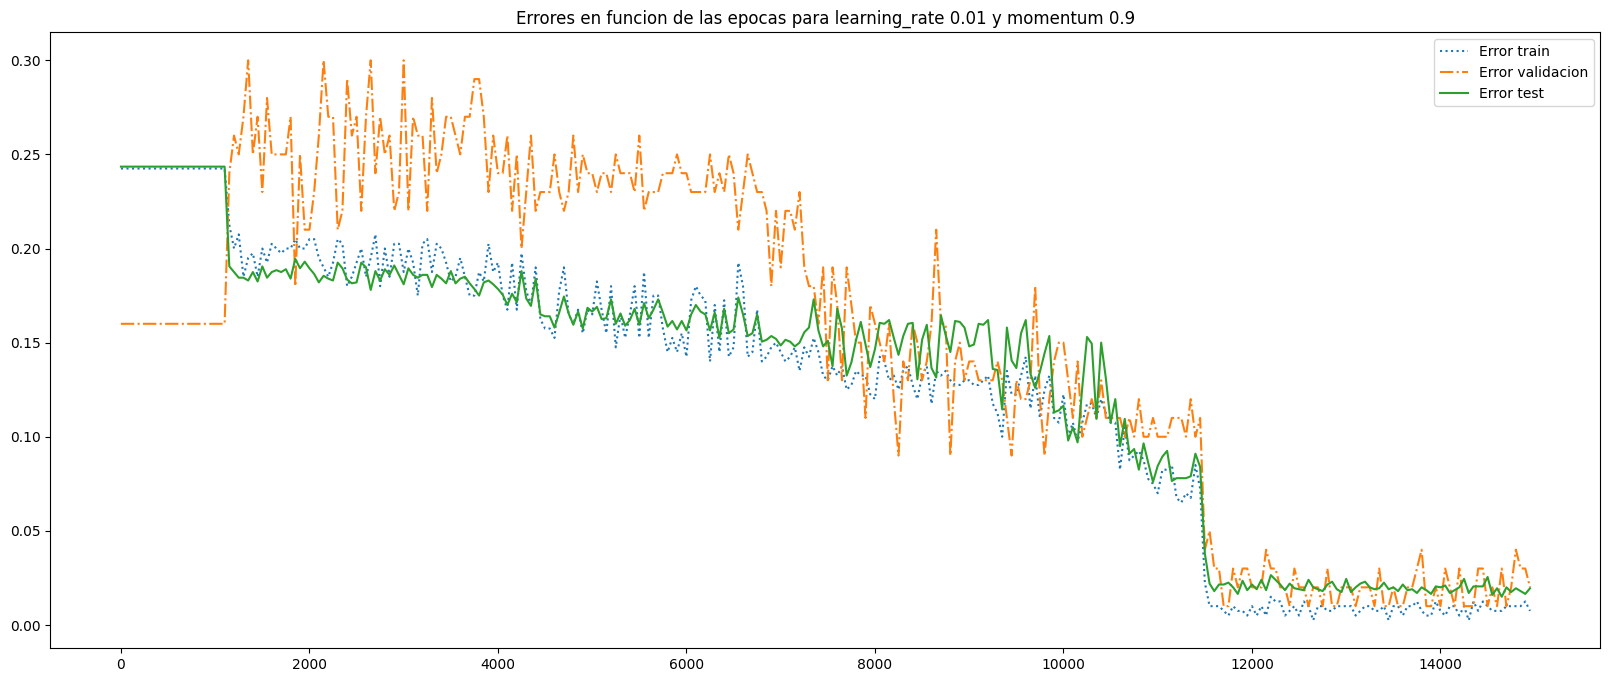

In [33]:
x_test, y_test = cargar_csv('dos_elipses.test')
x_data_tot, y_data_tot = cargar_csv('dos_elipses.data')

x_data, _, y_data, _ = skl.model_selection.train_test_split( x_data_tot, y_data_tot, test_size=0.5)
x_train, x_val, y_train, y_val = skl.model_selection.train_test_split( x_data, y_data, test_size=0.2)

sub_epocas=50    # numero de epocas que entrena cada vez
super_epocas=300 # numero de veces que realizaremos sub-epocas
N = 6            # neuronas en la capa oculta

lrS = [0.1, 0.01, 0.001] # learning rate
momentums = [0, 0.5, 0.9] # momentum
best_e_test = 1.0
best_red = {}
results = []
e_test,e_train, e_val = [],[],[]

for lr in lrS:
  for momentum in momentums:
    errorTestList = []
    for _ in range(10):
      net = MLPClassifier( hidden_layer_sizes=(N,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=lr,
                    nesterovs_momentum=False, momentum=momentum, tol=0.0, warm_start=True, max_iter=sub_epocas )

      # Corremos el entrenamiento
      red, e_train, e_val, e_test = entrenar_red( net, super_epocas, x_train, y_train, x_val, y_val, x_test, y_test )

      prediction = red.predict(x_test) 
      error_test = skl.metrics.zero_one_loss(y_test, prediction)

      errorTestList.append(error_test)

      # Guardamos la mejor red
      if (error_test < best_e_test):
        best_e_test = error_test
        best_red = { 'red': red, 'lr': lr, 'momentum': momentum, 'e_test': e_test, 'e_train': e_train, 'e_val': e_val}

    results.append([lr, momentum, np.mean(errorTestList)])

resultsDf = pd.DataFrame(results, columns=['Learning Rate', 'Momentum', 'Media Error Test'])

# Tabla de resultados
print(resultsDf)

# Graficamos los datos de la mejor red
rango = np.array(range(super_epocas)) * sub_epocas
plt.figure(figsize=(20, 8))
plt.plot(rango, best_red['e_train'], label="Error train", linestyle=":")
plt.plot(rango, best_red['e_val'], label="Error validacion", linestyle="-.")
plt.plot(rango, best_red['e_test'], label="Error test", linestyle="-")
plt.legend( )
plt.title( f'Errores en funcion de las epocas para learning_rate {best_red['lr']} y momentum {best_red['momentum']}')
plt.show()




## Comentarios
En base a la tabla de los errores medios obtenidos, podemos notar que independientemente del valor del learning rate, un valor alto del momentum suele disminuir significativamente el valor del error medio de la red. Esto puede deberse a que en este conjunto de datos existen muchos minimos locales, y que el incorporar momentum al calculo de los pesos de las neuronas ayuda a evitarlos y a aproximarse mas a un minimo global.
Con respecto al learning rate, en el caso de 0.01, vemos que el error medio 

# Ejercicio 3: Regularización

Baje el dataset Ikeda (en todos los problemas de regresión la última columna del dataset es la variable a precedir). Realice varios entrenamientos usando el 95% del archivo .data para entrenar, y el resto para validar. Realice otros entrenamientos cambiando la relación a 75%-25%, y a 50%-50%. En cada caso seleccione un resultado que considere adecuado, y genere gráficas del mse en train, validación y test. Comente sobre los resultados. 
Los otros parámetros para el entrenamiento son: learning rate 0.01, momentum 0.9, 2000 datos para testear, 400 evaluaciones del entrenamiento, cada una de 50 épocas, 30 neuronas en la capa oculta.

In [4]:
x_data_tot, y_data_tot = cargar_csv('ikeda.data', 5, dw = True)
x_test_tot, y_test_tot = cargar_csv('ikeda.test', 5, dw = True)

testDFFull = pd.read_csv('ikeda.test', delim_whitespace=True, names=['1', '2', '3', '4', '5', 'Clase'])
dataDF = pd.read_csv('ikeda.data', delim_whitespace=True, names=['1', '2', '3', '4', '5', 'Clase'])

testDF = testDFFull.sample(n=2000)
xTest = testDF[['1', '2', '3', '4', '5']].values
yTest = testDF['Clase'].values

xData = dataDF[['1', '2', '3', '4', '5']].values
yData = dataDF['Clase'].values

sub_epocas=50   # numero de epocas que entrena cada vez
super_epocas=400 # numero de veces que realizaremos sub-epocas
N = 30            # neuronas en la capa oculta
lr = 0.01 # learning rate
momentum = 0.9 # momentum

results = {}

def testRelacionVal( relacion):
  xTrain, xVal, yTrain, yVal = skl.model_selection.train_test_split( xData, yData, test_size = relacion)
  print( xTrain.shape, xVal.shape, xTest.shape)
  net = MLPRegressor( hidden_layer_sizes=(N,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=lr,
                nesterovs_momentum=False, momentum=momentum, tol=0.0, warm_start=True, max_iter=sub_epocas )

  red, e_train, e_val, e_test = entrenar_red( net, super_epocas, xTrain, yTrain, xVal, yVal, xTest, yTest )

  plt.figure(figsize=(20,8))
  rango = np.array(range(super_epocas)) * sub_epocas
  plt.plot(rango, e_train, label="Train", linestyle=":")
  plt.plot(rango, e_val, label="Val", linestyle="-.")
  plt.plot(rango, e_test, label="Test", linestyle="-")
  plt.legend()
  plt.title("Errores en funcion de las epocas para relacion de entrenamiento/validacion = " + str(100*(1-relacion)) + "% - " + str(100*relacion) + "%") 
  plt.show()

(95, 5) (5, 5) (2000, 5)


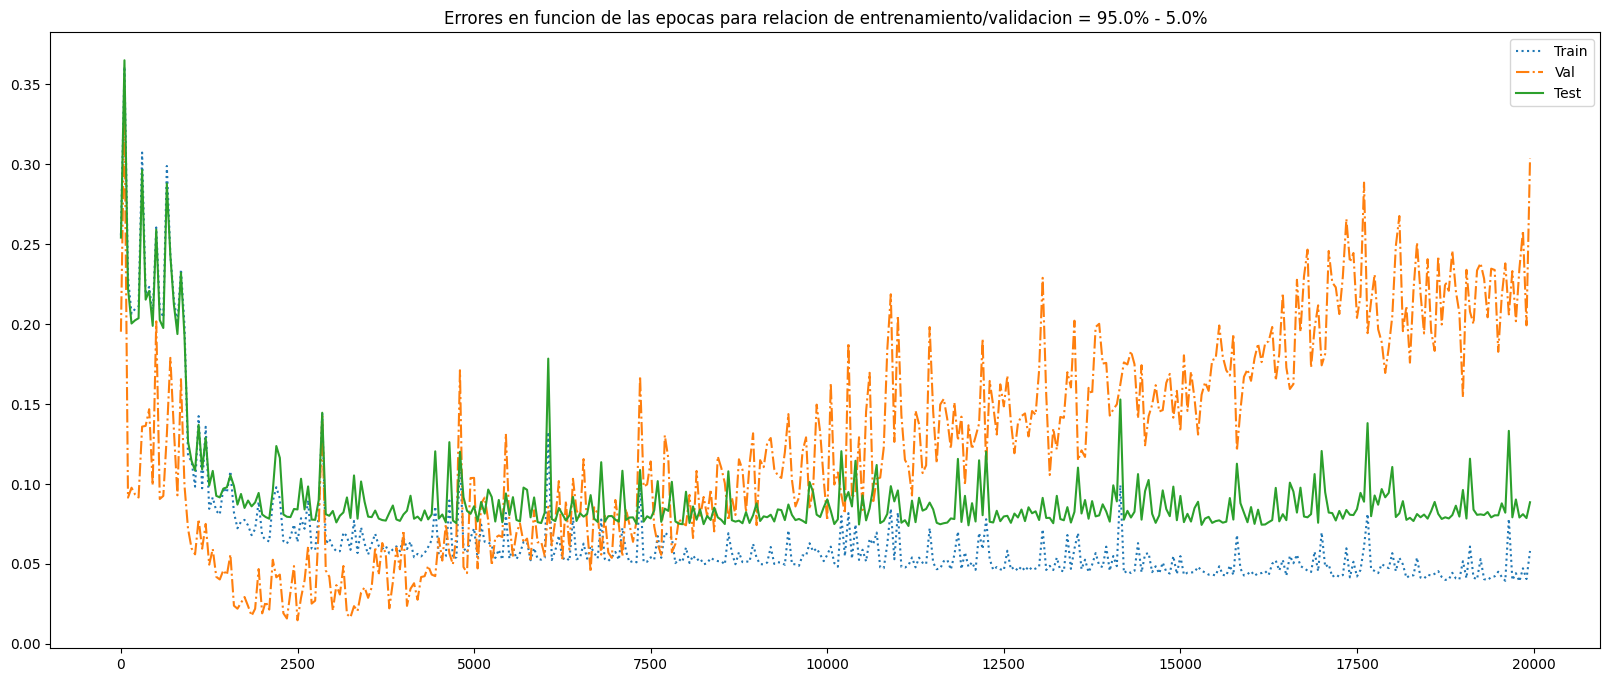

In [6]:
testRelacionVal(0.05)

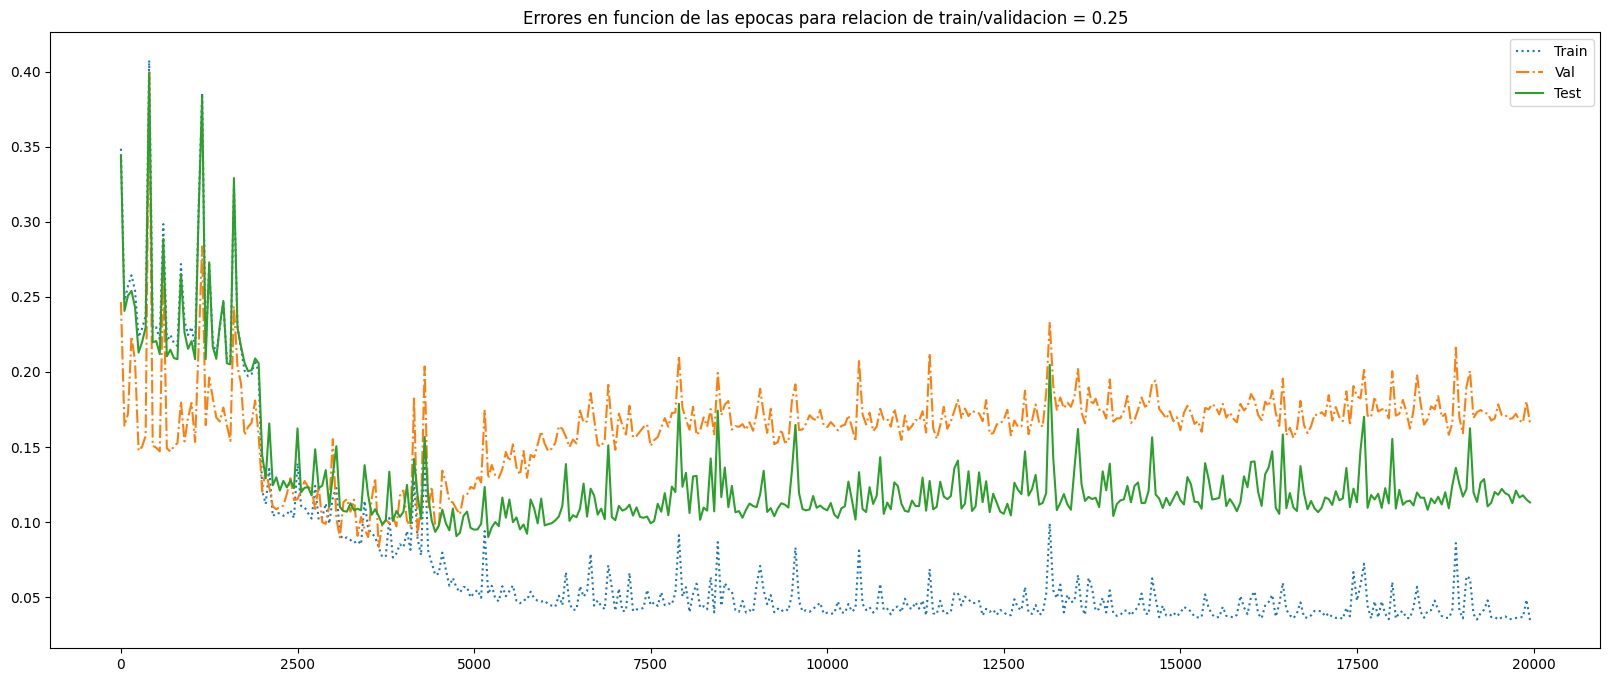

In [24]:
testRelacionVal(0.25)

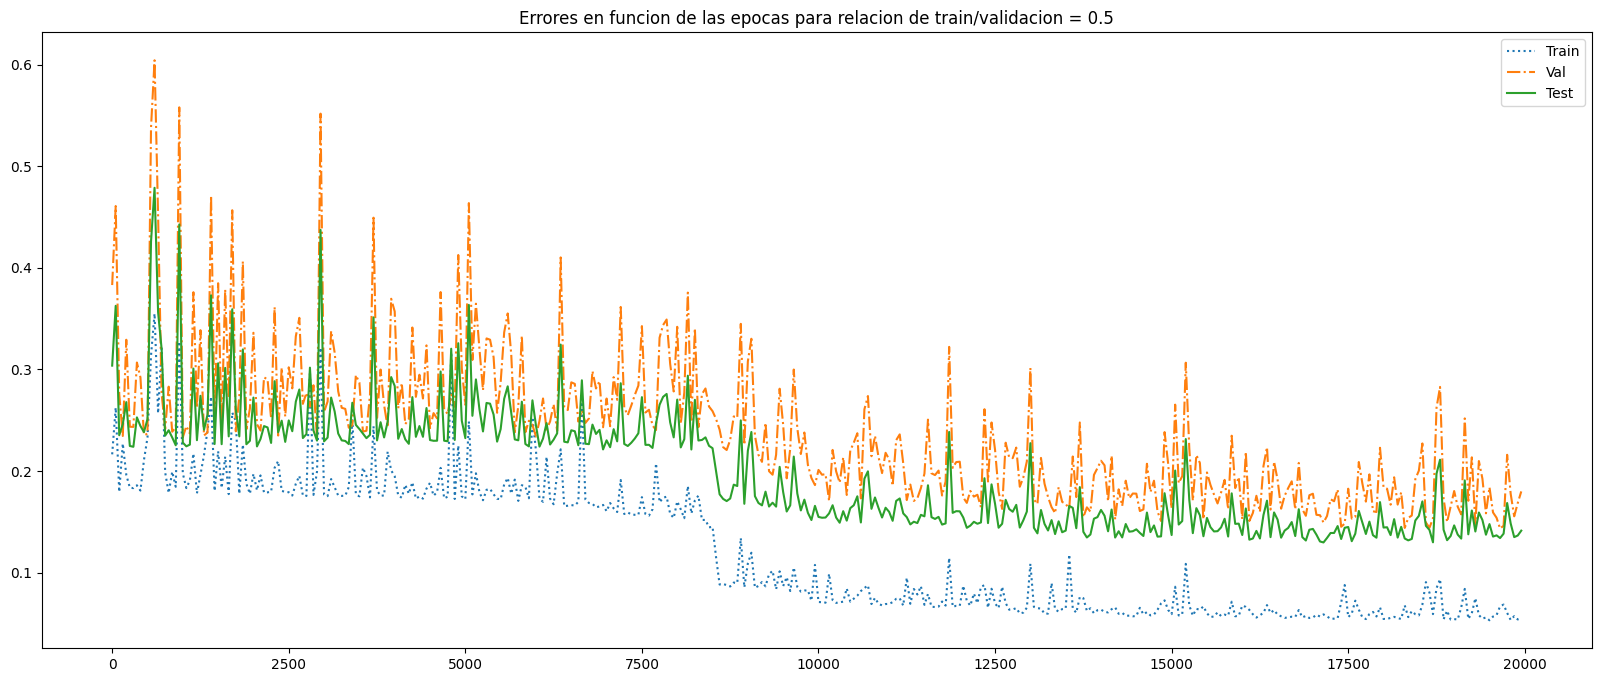

In [25]:
testRelacionVal(0.50)

## Comentarios

Baje el dataset Ikeda (en todos los problemas de regresión la última columna del dataset es la variable a precedir). Realice varios entrenamientos usando el 95% del archivo .data para entrenar, y el resto para validar. Realice otros entrenamientos cambiando la relación a 75%-25%, y a 50%-50%. En cada caso seleccione un resultado que considere adecuado, y genere gráficas del mse en train, validación y test. Comente sobre los resultados. 
Los otros parámetros para el entrenamiento son: learning rate 0.01, momentum 0.9, 2000 datos para testear, 400 evaluaciones del entrenamiento, cada una de 50 épocas, 30 neuronas en la capa oculta.

Analizando el caso en el que usamos el 95% de los datos para entrenar, con un 5% de validacion, vemos que el error del conjunto de validacion tiene un comportamiento muy erratico a medida que aumentan las epocas. Esto puede deberse a que al ser un conjunto de datos muy pequeños, pueden presentar particularidades que no se encuentran en el conjunto de test.

El caso 75%-25% es el mas equilibrado, y podemos ver como en el punto en el que el error de validacion es minimo, se encuentra la mejor red posible. Sin embargo, el error de test oscila entre 0.1 y 0.15, mientras que en el caso 95%-5% el mismo se encuentra mayormente por debajo del 0.1 cuando el de validacion es minimo.

Por ultimo, en el caso 50%-50% la mejor red se alcanza cuando el error de validacion es minimo. Pero al ser un conjunto reducido de datos de entrenamiento, el error de test es de 0.2, alcanzando a ser el doble que en el caso de 95%-5%.

Podemos concluir que un split de 50-50 adjudica muy pocos datos para el entrenamiento de la red, mientras que 95-5 hace que el error de validacion tenga un comportamiento demasiado erratico, lo que podria provocar que nos quedemos con una red suboptima. Es por esto que un caso balanceado como 75-25 parece ser la mejor alternativa para el caso general de entrenamiento de una red neuronal.

# Ejercicio 4: Regularización

Vamos a usar regularización por penalización, el weight-decay. Hay que tener cuidado con los nombres de los parámetros en este caso. El parámetro que nosotros llamamos gamma en la teoría corresponde en MLP de sklearn al parámetro alpha, mientras que nosotros usamos alfa para el momentum en general.

En este tipo de regularización no se usa un conjunto de validación, asi que hay que modificar la función que crearon para evaluar el entrenamiento de las redes, para que en lugar del error sobre el conjunto de validación, nos devuelva la suma de los valores absolutos o de los valores al cuadrado de todos los pesos de la red en la epoca correspondiente, y todo el resto igual que antes.

Una vez implementado, aplíquelo al dataset Sunspots (ssp). Busque el valor de gamma adecuado para conseguir un equilibrio entre evitar el sobreajuste y hacer el modelo demasiado rígido (el valor de gamma se debe variar en varios órdenes de magnitud, por ejemplo empezar en 10^-6 e ir hasta 10^0 (1) de a un orden cada vez). En este caso todos los registros del archivo .data se deben usar para el entrenamiento, ya que la regularización se realiza con la penalización a los pesos grandes. 
Los otros parámetros se pueden tomar: learning rate 0.05, momentum 0.3, 4000 evaluaciones del entrenamiento, cada una de 20 épocas, 6 neuronas en la capa intermedia.

Entregue curvas de los tres errores (entrenamiento y test en una figura, penalización en otra figura) para el valor de gamma elegido, y para algún otro valor en que haya observado sobreajuste. Comente los resultados.

In [137]:
gammas=[0.00001, 0.0001, 0.001, 0.01, 0.1, 1]

sub_epocas = 20
super_epocas = 4000
N2 = 6
lr = 0.05
alfa = 0.03

x_train, y_train = cargar_csv("ssp.data", 12)
x_test, y_test = cargar_csv("ssp.test", 12)

errores = {}

for gamma in gammas:
  regr = MLPRegressor(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=gamma, batch_size=1, learning_rate='constant', 
                      learning_rate_init=lr,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=sub_epocas)
  red, errors_train, errors_test, weights = entrenar_red_weight(regr, super_epocas, x_train, y_train, x_test, y_test)
  errores[gamma] = [errors_train, errors_test, weights]  

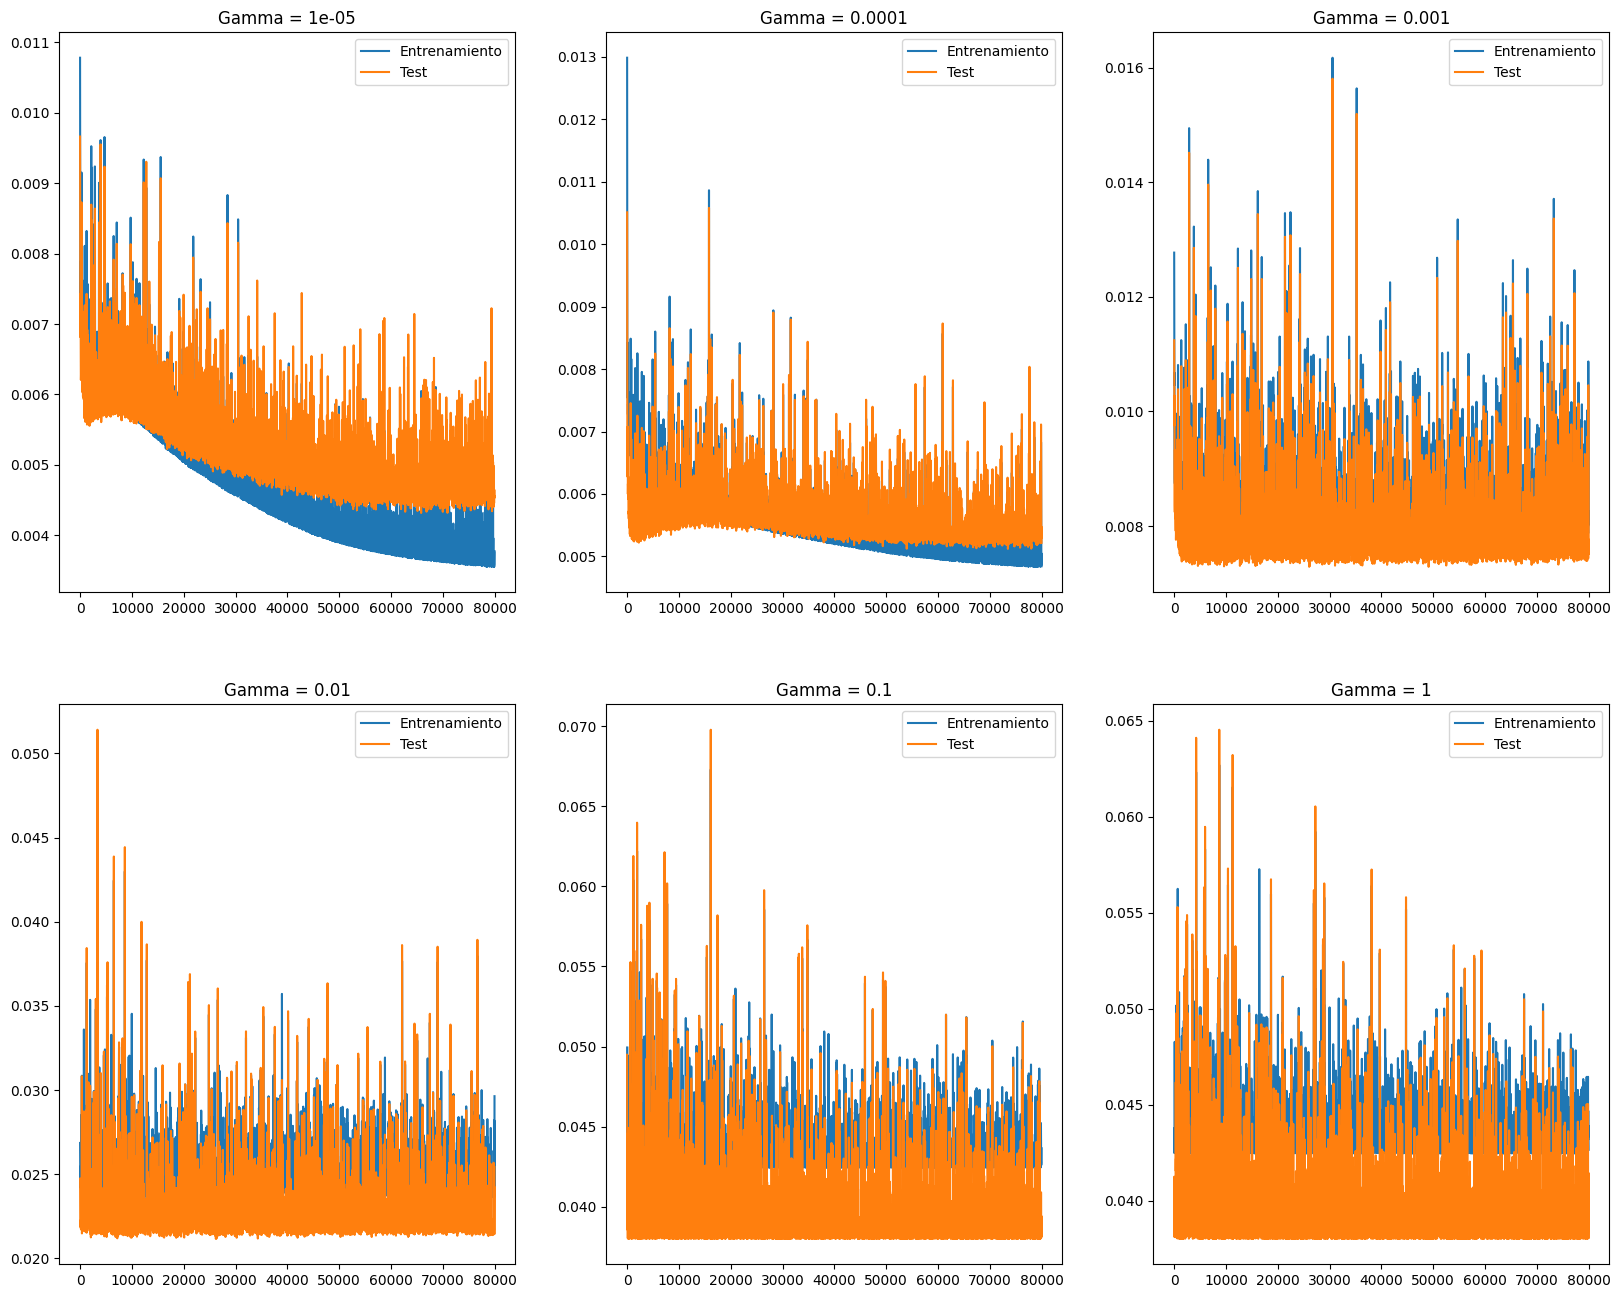

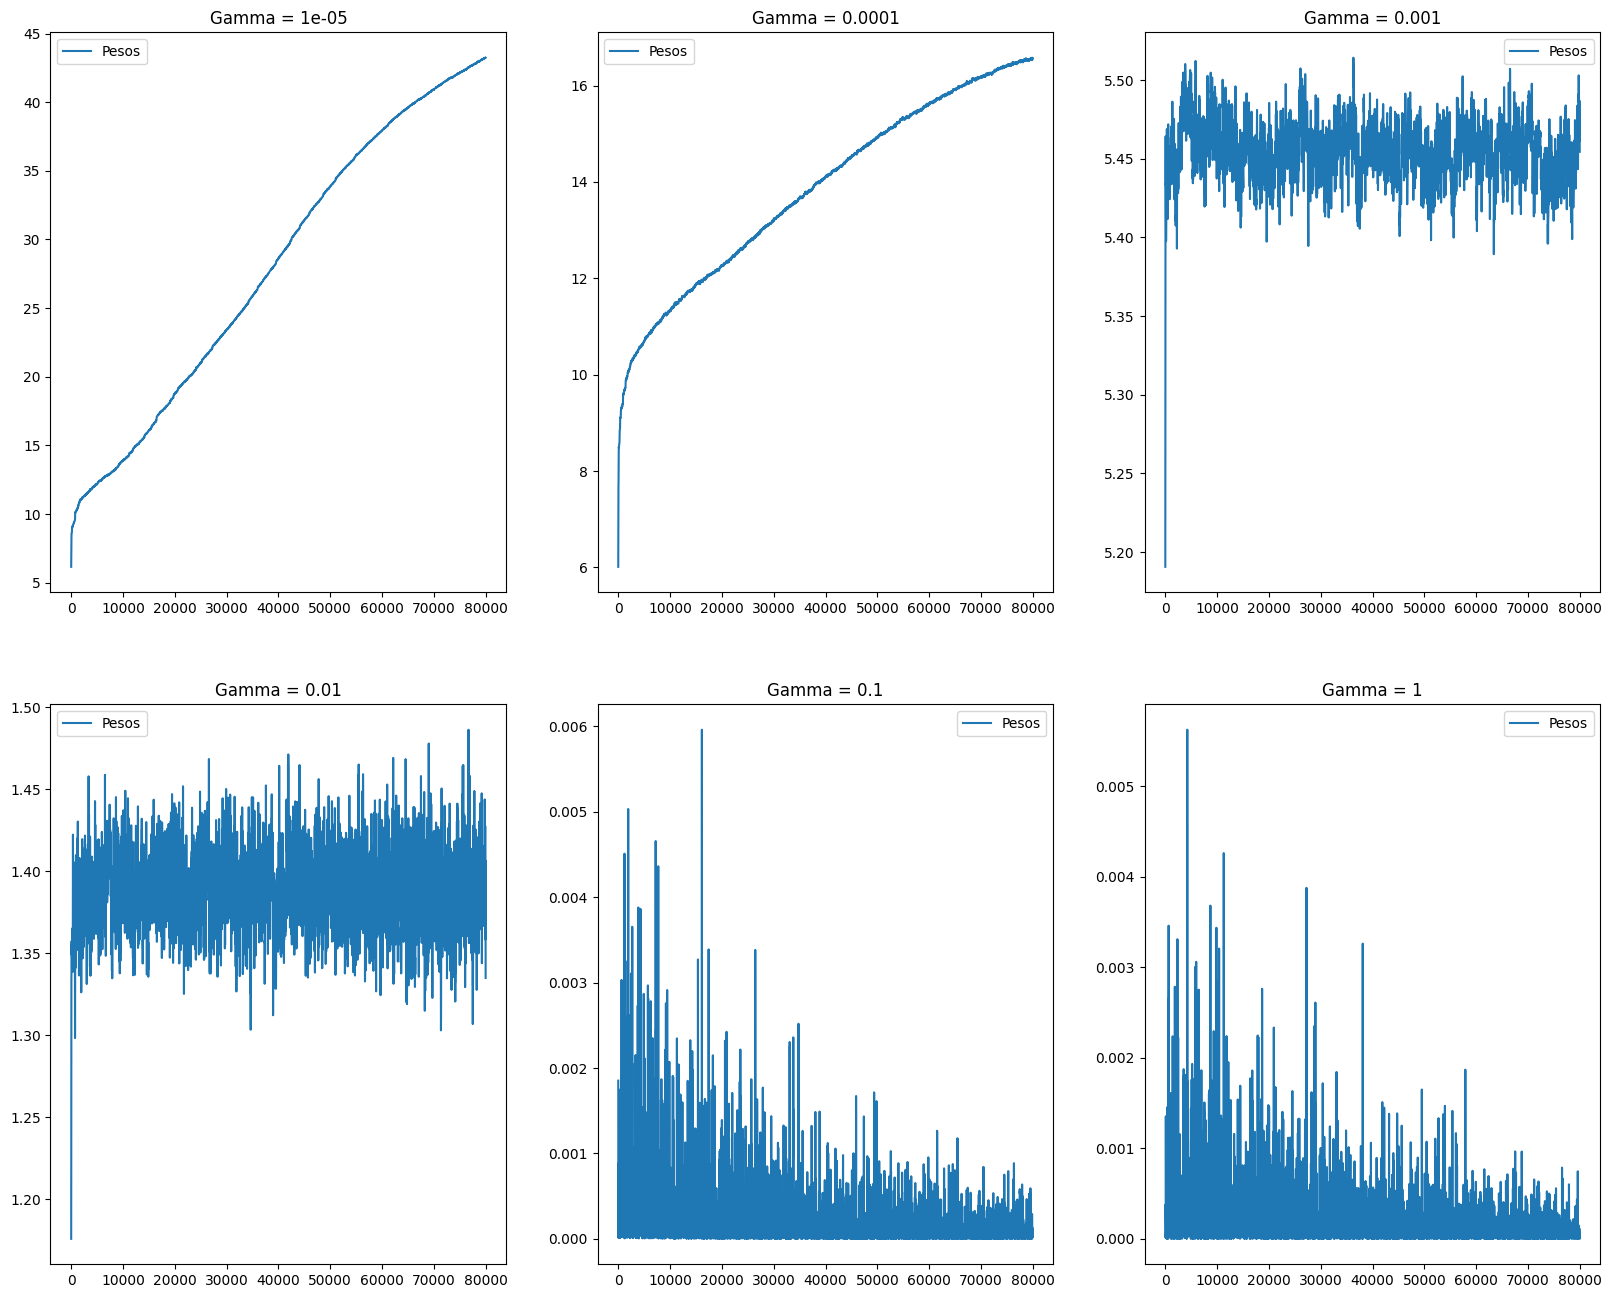

In [138]:
fig1, axis1 = plt.subplots(2, 3)
fig2, axis2 = plt.subplots(2, 3)
fig1.set_size_inches(20, 16)
fig2.set_size_inches(20, 16)
sub_epocas = 20
super_epocas = 4000
rango = np.array(range(super_epocas)) * sub_epocas

for gamma, ax1, ax2 in zip(gammas, axis1.flatten(), axis2.flatten()):
  errors_train, errors_test, weights = errores[gamma]
  ax1.plot(rango,errors_train, label="Entrenamiento", linestyle="-")
  ax1.plot(rango,errors_test, label="Test", linestyle="-")
  ax1.legend()
  ax1.set_title(f"Gamma = {gamma}")
  ax2.plot(rango,weights, label="Pesos", linestyle="-")
  ax2.legend()
  ax2.set_title(f"Gamma = {gamma}")

In [139]:
error_final = {gamma: [errores[gamma][0][-1], errores[gamma][1][-1], errores[gamma][2][-1]] for gamma in gammas}
df = pd.DataFrame([[gamma, *error_final[gamma]] for gamma in gammas], columns=["Gamma", "Error train", "Error test", "Pesos"])
print(df)

     Gamma  Error train  Error test      Pesos
0  0.00001     0.003774    0.004554  43.238491
1  0.00010     0.004842    0.005218  16.565554
2  0.00100     0.008256    0.007759   5.454409
3  0.01000     0.029630    0.025425   1.334999
4  0.10000     0.043654    0.038199   0.000121
5  1.00000     0.042641    0.038054   0.000002


## Comentarios

Al hacer el experimento con gamma 1 y 0.1 los pesos en la red eran muy pequeños por lo cual la red era muy éstricta con los cortes, haciendo que el error aumente. Con gamma 0.01 y 0.001 los pesos no crecen demasiado pero aún así son más grandes, y la red se ajusta más a los datos de entrenamiento y test. Por último, con 0.0001 y 0.00001 la red no regulariza (los pesos son crecientes) y sin un conjunto de validación la red continúa sobreajustando cuando el mínimo del conjunto de tests ya se alcanzó. Además, en todos los experimentos vemos que el procedimiento de realizar pequeños ajustes a la red entre épocas produce grandes variaciones en el rendimiento de la red con picos en toda la gráfica, lo cual se atribuye a la naturaleza caótica del problema. También puede deberse a un efecto de la regularización.

Vemos que el nivel de error disminuye con valores más bajos. El error de los tests es bajo como el de entrenamiento lo cual nos sorprende pero suponemos que se debe a que el conjunto de tests no es lo suficientemente grande e independiente del conjunto de entrenamiento.

La teoría indica que usando un valor muy bajo de gamma la red esta sobreajustando al conjunto de entrenamiento por lo que no generaliza bien. Es preferible una red con un gamma mas moderado como 0.001 y 0.01 que tienen una suma de pesos de 5.45 y 1.37 porque nos dan la certeza de que se utiliza una solución más sencilla que generaliza mejor.

Cabe aclarar que consideramos sumas de pesos bajas a 5.45 y 1.37 debido al numero de nodos en la capa oculta. Al ser 6 nodos intermedios, la suma de sus pesos al cuadrado debe ser menor a 6 para estar en el intervalo de la sigmoide que es mas o menos lineal.

# Ejercicio 5: Dimensionalidad
Repita el punto 4 del Práctico 1, usando ahora redes con 6 unidades en la capa intermedia. Los otros parámetros hay que setearlos adecuadamente, usando como guía los casos anteriores. Genere una gráfica que incluya los resultados de redes y árboles.

## Generacion de datos

In [21]:
import math as m
import numpy as np
import pandas as pd
PI = np.pi

np.random.seed(0)

def diagonales(n, d, C):

  desv = C * m.sqrt(d)

  media1 =  np.full(d,-1)
  media2 =  np.full(d,1)

  cov = np.diag( np.full(d, desv**2) )

  r1 = np.random.multivariate_normal(media1, cov, n//2)
  r2 = np.random.multivariate_normal(media2, cov, n//2)

  r = np.concatenate((r1, r2))
  c = np.concatenate((np.full(n//2, 1), np.full(n//2, 2)))


  return pd.DataFrame( { "c1": r.tolist(), "c2": c.tolist()} )

def paralelas(n, d, C):
  desv = C

  media1 =  np.full(d,0)
  media2 =  np.full(d,0)

  media1[0] = -1
  media2[0] = 1

  cov = np.diag( np.full(d, desv**2) )

  r1 = np.random.multivariate_normal(media1, cov, n//2)
  r2 = np.random.multivariate_normal(media2, cov, n//2)

  r = np.concatenate((r1, r2))
  c = np.concatenate((np.full(n//2, 1), np.full(n//2, 2)))


  return pd.DataFrame( { "c1": r.tolist(), "c2": c.tolist()} )

## Parametros generales

In [22]:
sub_epocas=10   # numero de epocas que entrena cada vez
super_epocas=10 # numero de veces que realizaremos sub-epocas

N2 = 6
gamma = 0.001
alfa = 0.01

C = 0.78
nTrain = 250
nTest = 10000
dimensiones = [2, 4, 8, 16, 32]
datasets = 20
lr = 0.05

from sklearn.tree import DecisionTreeClassifier

## Paralelas

In [23]:
resultados_arbol_paralelas = {}
resultados_red_paralelas = {}

for d in dimensiones:
  error_arbol_pm = 0
  error_red_pm = 0

  for _ in range(datasets):
    train = paralelas(nTrain, d, C)
    test  = paralelas(nTest, d, C)

    x_train = train['c1'].values.tolist()
    y_train = train['c2'].values.tolist()
    x_test  = test['c1'].values.tolist()
    y_test  = test['c2'].values.tolist()

    clf = DecisionTreeClassifier(criterion="entropy", min_impurity_decrease=0.002, random_state=0, min_samples_leaf=5)
    clf.fit(x_train, y_train)

    prediccion_arbol = clf.predict(x_test)
    error_arbol = skl.metrics.zero_one_loss(y_test, prediccion_arbol)
    error_arbol_pm += error_arbol / datasets

    clas = MLPClassifier(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=gamma, batch_size=1, learning_rate='constant', 
                         learning_rate_init=lr,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=sub_epocas)
    red, _, errors_test, _ = entrenar_red_weight(clas, super_epocas, x_train, y_train, x_test, y_test)

    error_red = errors_test[-1]
    error_red_pm += error_red / datasets

  resultados_arbol_paralelas[d] = error_arbol_pm
  resultados_red_paralelas[d] = error_red_pm

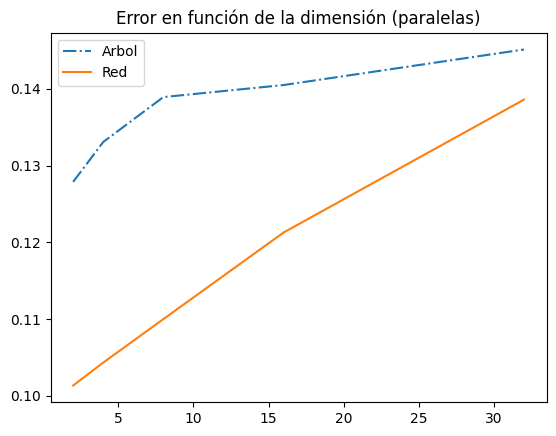

In [24]:
plt.plot(dimensiones, resultados_arbol_paralelas.values(), label="Arbol", linestyle="-.")
plt.plot(dimensiones, resultados_red_paralelas.values(), label="Red", linestyle="-")
plt.title("Error en función de la dimensión (paralelas)")
plt.legend()
plt.show()

## Diagonales

In [25]:
resultados_arbol_diagonales = {}
resultados_red_diagonales = {}

for d in dimensiones:
  error_arbol_pm = 0
  error_red_pm = 0

  for _ in range(datasets):
    train = diagonales(nTrain, d, C)
    test  = diagonales(nTest, d, C)

    x_train = train['c1'].values.tolist()
    y_train = train['c2'].values.tolist()
    x_test  = test['c1'].values.tolist()
    y_test  = test['c2'].values.tolist()

    clf = DecisionTreeClassifier(criterion="entropy", min_impurity_decrease=0.002, random_state=0, min_samples_leaf=5)
    clf.fit(x_train, y_train)

    prediccion_arbol = clf.predict(x_test)
    error_arbol = skl.metrics.zero_one_loss(y_test, prediccion_arbol)
    error_arbol_pm += error_arbol / datasets

    clas = MLPClassifier(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=gamma, batch_size=1, learning_rate='constant', 
                         learning_rate_init=lr,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=sub_epocas)
    red, _, errors_test, _ = entrenar_red_weight(clas, super_epocas, x_train, y_train, x_test, y_test)

    error_red = errors_test[-1]
    error_red_pm += error_red / datasets

  resultados_arbol_diagonales[d] = error_arbol_pm
  resultados_red_diagonales[d] = error_red_pm

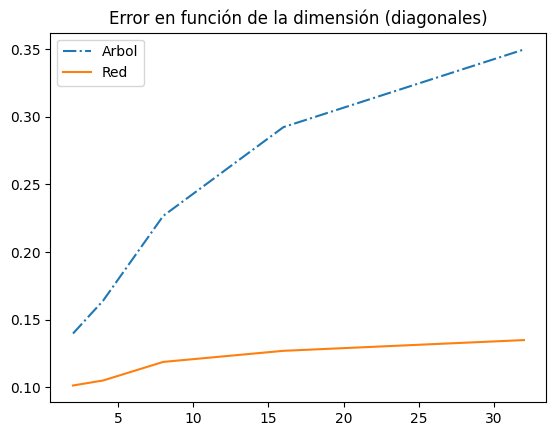

In [26]:
plt.plot(dimensiones, resultados_arbol_diagonales.values(), label="Arbol", linestyle="-.")
plt.plot(dimensiones, resultados_red_diagonales.values(), label="Red", linestyle="-")
plt.title("Error en función de la dimensión (diagonales)")
plt.legend()
plt.show()

## Comentarios

Usamos una red entrenada con pocas epocas y un learning rate moderado, para no producir tantos saltos en la busqueda, principalmente para ahorrar tiempo. Sin embargo, los resultados nos permiten concluir que las redes neuronales mejoran mucho el desempeño de los arboles para reconocer patrones en espacios de alta dimensionalidad. Las redes neuronales parecen no verse afectadas por la dimensionalidad. En especial, el error se mantiene por debajo del 15% en ambos experimentos.

En el problema de las paralelas la gráfica del error en los arboles está junto al error de las redes neuronales, debido a que es un problema con una solución muy sencilla a la que el arbol puede llegar sin problemas: hacer un corte dividiendo las x positivas de las x negativas. Por esa razón no es afectado tan negativamente por la dimensionalidad. Conclusión a la que también llegamos en el TP anterior. Ahora podemos ver que las redes son similares en este aspecto y aun mejores.